# 4.3.2.
Relativamente aos dados da **Alemanha** e do poluente **PM2.5**:
1. Determinar o modelo de regressão linear
2. Verificar as condições sobre os resíduos
3. Verificar se existe colinearidade
4. Comentar o modelo obtido, tendo em conta todas as características relevantes para a qualidade do modelo
5. Estimar o número de mortes para regiões com **NUTS Code**: **DE131**,**DE132**,**DE133**,**DE134**,**DE135**,**DE136**,**DE137**,**DE138** e **DE139** e comparar com os valores reais

## *Imports* estáticos

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Leitura dos dados

In [183]:
significancia = 0.05

dados = pd.read_csv('../dados/AIRPOL_data.csv', delimiter=";", header=0)
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'])
dados_alemanha = dados[(
    (dados['Country']=='Germany')
#    | (dados['Country']=='All Countries') # Se este dado for utilizado, introduzimos uma série de valores que irão perturbar com o modelo da regressão
    ) 
    & (dados['Air_Pollutant']=='PM2.5')]
dados_alemanha = dados_alemanha.filter(['NUTS_Code', # Pedido em e)
                                         'Value', # Y - Número de mortes prematuras
                                         'Populated_Area[km2]', # X2 - Área da região afetada
                                         'Air_Pollution_Average[ug/m3]' # X1 - Nível médio de poluição
                                         ])
dados_alemanha['Value'] = dados_alemanha['Value'].str.replace(',', '.').astype(float)
dados_alemanha['Populated_Area[km2]'] = dados_alemanha['Populated_Area[km2]'].str.replace(',', '.').astype(float)
dados_alemanha['Air_Pollution_Average[ug/m3]'] = dados_alemanha['Air_Pollution_Average[ug/m3]'].str.replace(',', '.').astype(float)
dados_alemanha

,NUTS_Code,Value,Populated_Area[km2],Air_Pollution_Average[ug/m3]
1262,DE,3115.0,213783.4,8.4
1268,DE1,343.0,22303.3,7.5
2868,DE11,140.0,6663.3,8.2
2869,DE111,24.0,191.5,9.3
2871,DE112,12.0,383.9,8.1
...,...,...,...,...
47364,DEG0K,4.0,553.4,7.7
47478,DEG0L,6.0,570.0,8.4
47706,DEG0M,6.0,429.7,9.0
47754,DEG0N,2.0,57.4,8.1


## Determinação do modelo de regressão linear

In [184]:
X = dados_alemanha[['Air_Pollution_Average[ug/m3]', 'Populated_Area[km2]']]
Xc = sm.add_constant(X)
y = dados_alemanha['Value']
modelo=sm.OLS(y,Xc)
resultados=modelo.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     2622.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:39:05   Log-Likelihood:                -70030.
No. Observations:                8208   AIC:                         1.401e+05
Df Residuals:                    8205   BIC:                         1.401e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -443.7988    119.109     -3.726      0.000    -677.282    -210.316
Air_Pollution_Average[ug/m3]    52.1364     13.840      3.767      0.000      25.007      79.266
Populated_Area[km2]              0.0928      0.001     72.371      0.000       0.090       0.095
==============================================================================
Omnibus:                    20108.717   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        742457869.753
Skew:                          25.325   Prob(JB):                         0.00
Kurtosis:                    1475.537   Cond. No.                     9.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Verificar resíduos

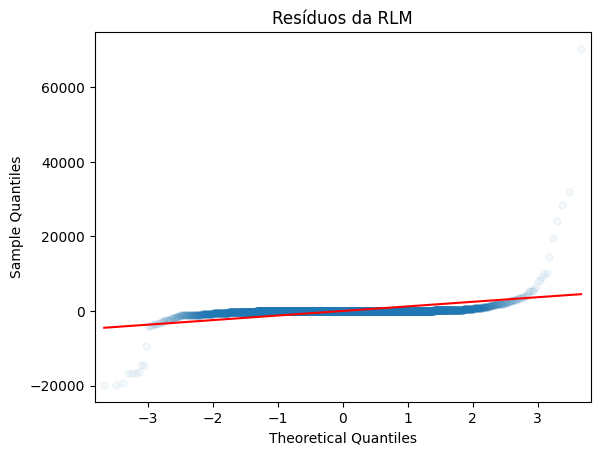

In [185]:
residuos = resultados.resid
sm.qqplot(residuos, line='s', markersize=5, alpha=significancia)
plt.title('Resíduos da RLM')
plt.show()

## Verificação de colinearidade

In [186]:
vif_res = pd.DataFrame()
vif_res["variaveis"]=X.columns
vif_res["VIF"]=[variance_inflation_factor(X.values,i)
                for i in range(len(X.columns))]
vif_res

,variaveis,VIF
0,Air_Pollution_Average[ug/m3],1.030255
1,Populated_Area[km2],1.030255


Com isto, concluímos que não há colinearidade significativa entre as variáveis independentes (VIF ≈ 1.03 ≈ 1)
## Comentar o modelo obtido tendo em conta todas as características relevantes para a qualidade do modelo
Visto que os valores de R ao quadrado e R ao quadrado ajustado são baixos (0.390), podemos concluir que a qualidade do modelo não é a mais desejada. Isto deve-se ao facto que o número de mortes devido ao poluente **PM2.5** depende de outros fatores, como o resultado da poluição (**Outcome**).
## Estimar o número de mortes para as regiões previamente indicadas e comparar com os valores reais
Aqui, iremos usar o modelo de regressão linear para, com cada uma das regiões pedidas, comparar o valor estimado com o valor real (média de todos os valores).

In [187]:
regioes=['DE131','DE132','DE133','DE134','DE135','DE136','DE137','DE138','DE139']
medias = []
estimativas = []
diferencas = []

const = resultados.params.iloc[0]
coef_poluicao = resultados.params.iloc[1]
coef_area = resultados.params.iloc[2]

for regiao in regioes:
    # Nós sabemos que num dado NUTS Code a Populated Area e a Air Pollution Average nunca mudam, independente do poluente, número de mortes prematuras, etc.
    area = dados_alemanha[dados_alemanha['NUTS_Code']==regiao]['Populated_Area[km2]'].astype(float).iloc[0]
    poluicao = dados_alemanha[dados_alemanha['NUTS_Code']==regiao]['Air_Pollution_Average[ug/m3]'].astype(float).iloc[0]

    media = dados_alemanha[dados_alemanha['NUTS_Code']==regiao]['Value'].astype(float).mean()
    medias.append(media)

    estimativa = const + coef_poluicao * poluicao + coef_area * area
    estimativas.append(estimativa)

    diferencas.append(abs(media-estimativa))

df = pd.DataFrame({
    "Média Real": medias,
    "Estimativa": estimativas,
    "Diferença": diferencas
})
df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(regioes, axis=0)

,MÉDIA REAL,ESTIMATIVA,DIFERENÇA
DE131,"37,722","-32,342","70,064"
DE132,"42,556","-30,722","73,278"
DE133,"29,556","-29,688","59,244"
DE134,"85,500","60,325","25,175"
DE135,"18,056","-64,714","82,770"
DE136,"24,278","-86,971","111,248"
DE137,"16,722","-83,798","100,521"
DE138,"50,944","-4,505","55,449"
DE139,"41,833","-35,558","77,391"
